# Load Dataset

MovieLens 1M dataset (https://grouplens.org/datasets/movielens/)


In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

my_drive = '/content/gdrive/MyDrive'
path = os.path.join(my_drive, "AISIA/Winter School 2020")
data_dir = os.path.join(path, "data")

Mounted at /content/gdrive


In [2]:
import pandas as pd

movies_df = pd.read_csv("/content/gdrive/MyDrive/AISIA/Winter School 2020/data/movies.dat", 
                        sep="::",
                        names=['movie_id', 'title', 'genre'])
movies_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings_df = pd.read_csv("/content/gdrive/MyDrive/AISIA/Winter School 2020/data/ratings.dat",
                         sep="::",
                         names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
users_df = pd.read_csv("/content/gdrive/MyDrive/AISIA/Winter School 2020/data/users.dat", 
                       sep="::",
                       names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
users_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Merge dataset

In [5]:
#Merge the ratings and users with movieID and UserID
ratings_user = pd.merge(ratings_df, users_df, on=['user_id'])
ratings_movie = pd.merge(ratings_df, movies_df, on=['movie_id'])

master_data = pd.merge(ratings_user,ratings_movie,
                       on=['user_id', 'movie_id', 'rating'])[['movie_id', 'title', 'user_id', 'age', 'gender', 'occupation', "rating"]]

master_data.head()

,movie_id,title,user_id,age,gender,occupation,rating
0,1193,One Flew Over the Cuckoo's Nest (1975),1,1,F,10,5
1,661,James and the Giant Peach (1996),1,1,F,10,3
2,914,My Fair Lady (1964),1,1,F,10,3
3,3408,Erin Brockovich (2000),1,1,F,10,4
4,2355,"Bug's Life, A (1998)",1,1,F,10,5


# Data Analysis

<function matplotlib.pyplot.show>

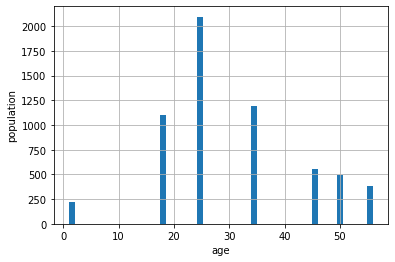

In [6]:
#User age distribution
import matplotlib.pyplot as plt

users_df['age'].hist(bins=50)
plt.xlabel('age')
plt.ylabel('population')
plt.show

age
1     112
18    448
25    790
35    423
45    143
50    108
56     53
Name: movie_id, dtype: int64

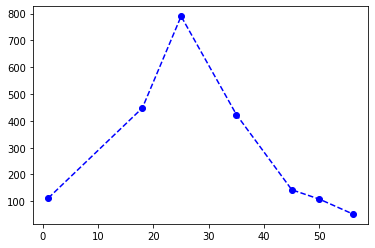

In [7]:
#User rating of the movie “Toy Story”

res = master_data[master_data.title == "Toy Story (1995)"]

plt.plot(res.groupby("age")["movie_id"].count(),'--bo')
res.groupby("age")["movie_id"].count()

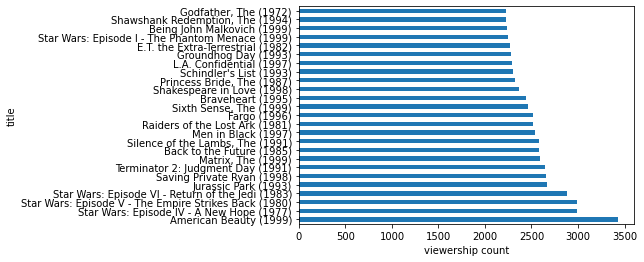

In [8]:
#Top 25 movies by viewership rating

res = master_data.groupby("title").size().sort_values(ascending=False)[:25]
plt.ylabel("title")
plt.xlabel("viewership count")
res.plot(kind="barh")

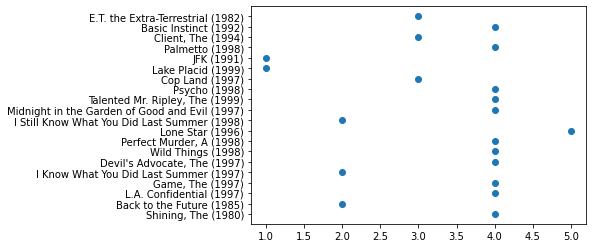

In [9]:
#Find the ratings for all the movies reviewed by for a particular user of user id = 2696

res = master_data[master_data["user_id"] == 2696]

plt.scatter(y=res["title"], x=res["rating"])

In [10]:
#Feature Engineering

val = movies_df["genre"].str.split("|")

res_col = []
for v in val:
    for i in v:
        if i not in res_col:
            res_col.append(i)

res_col.append("gender")
res_col.append("age")
res_col.append("rating")

In [11]:
import numpy as np

# Join master data with movies dataframe
res = master_data.merge(movies_df, on = ['movie_id'], how="left")[["genre", "rating", "gender", "age"]]

# Create main df to input into the model
df = pd.DataFrame(columns=res_col)

df[["genre", "rating", "gender", "age"]] = res[["genre", "rating", "gender", "age"]]
df.fillna(0, inplace=True)

In [12]:
def expand_genres(row):
    for genre in row["genre"].split("|"):
        row[genre] = 1
    return row

df = df.apply(expand_genres, axis=1)
del df["genre"]

df.head()

,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western,gender,age,rating
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,F,1,5
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,F,1,3
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,F,1,3
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,F,1,4
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,F,1,5


# Model

In [13]:
len(df)

1000209

In [37]:
from sklearn import datasets 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

X = df[df.columns[~df.columns.isin(["rating"])]]
y = df["rating"]

# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

number = LabelEncoder()
X_train["gender"] = number.fit_transform(X_train["gender"].astype("str"))
X_test["gender"] = number.fit_transform(X_test["gender"].astype("str"))
y_train = number.fit_transform(y_train.astype("int"))
y_test = number.fit_transform(y_test.astype("int"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
# Linear model
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression(n_jobs=-1)

linear_reg.fit(X_train, y_train)
predictions = linear_reg.predict(X_test) 
  
mean_absolute_error(y_test, predictions)

0.26875902308710553

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_jobs=-1)

rf_reg.fit(X_train, y_train)
predictions = rf_reg.predict(X_test) 
  
mean_absolute_error(y_test, predictions)

0.8686227918586588

In [39]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(solver='adam', 
                    activation="relu",
                    # alpha=1e-5,
                    learning_rate="adaptive",
                    learning_rate_init=0.001,
                    hidden_layer_sizes=(100), 
                    max_iter=100,
                    tol=0.001,
                    random_state=1,
                    verbose=True)

mlp_reg.fit(X_train, y_train)
predictions = mlp_reg.predict(X_test) 
  
mean_absolute_error(y_test, predictions)

Iteration 1, loss = 0.65352022
Iteration 2, loss = 0.59440943
Iteration 3, loss = 0.58965811
Iteration 4, loss = 0.58717300
Iteration 5, loss = 0.58504206
Iteration 6, loss = 0.58364978
Iteration 7, loss = 0.58265150
Iteration 8, loss = 0.58175656
Iteration 9, loss = 0.58084027
Iteration 10, loss = 0.58042263
Iteration 11, loss = 0.57934956
Iteration 12, loss = 0.57914772
Iteration 13, loss = 0.57840403
Iteration 14, loss = 0.57795036
Iteration 15, loss = 0.57767461
Iteration 16, loss = 0.57757156
Iteration 17, loss = 0.57743079
Iteration 18, loss = 0.57707968
Iteration 19, loss = 0.57692202
Iteration 20, loss = 0.57677858
Iteration 21, loss = 0.57648897
Iteration 22, loss = 0.57651429
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.


0.2680391756947527